In [ ]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './data2/'

# load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'Train/Image')
y_train_dir = os.path.join(DATA_DIR, 'Train/Mask')

x_valid_dir = os.path.join(DATA_DIR, 'Test/Image')
y_valid_dir = os.path.join(DATA_DIR, 'Test/Mask')

x_test_dir = os.path.join(DATA_DIR, 'Test/Image')
y_test_dir = os.path.join(DATA_DIR, 'Test/Mask')

classes = ['10','30','50','70','90','115','135','165', '195', '210']

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for z, (name, image) in enumerate(images.items()):
        print(image.shape)
        if image.shape[2] == 1 or image.shape[2] == 3:
            plt.subplot(1, n, z + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        else:
            a,b,c,d,e,f,g,h,i,j = cv2.split(image)
            a = a*10
            b = b*30
            c = c*50
            d = d*70
            e = e*90
            f = f*115
            g = g*135
            h = h*165
            i = i*195
            j = j*210
            image2 = a+b+c+d+e+f+g+h
            plt.subplot(1, n, z + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image2, cmap='gray')
            print(np.unique(image2))
            
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['10','30','50','70','90','115','135','165', '195', '210']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [int(cls) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(500, 500, 3)
(500, 500, 10)
[ 10.  30.  50.  70.  90. 115. 135.]


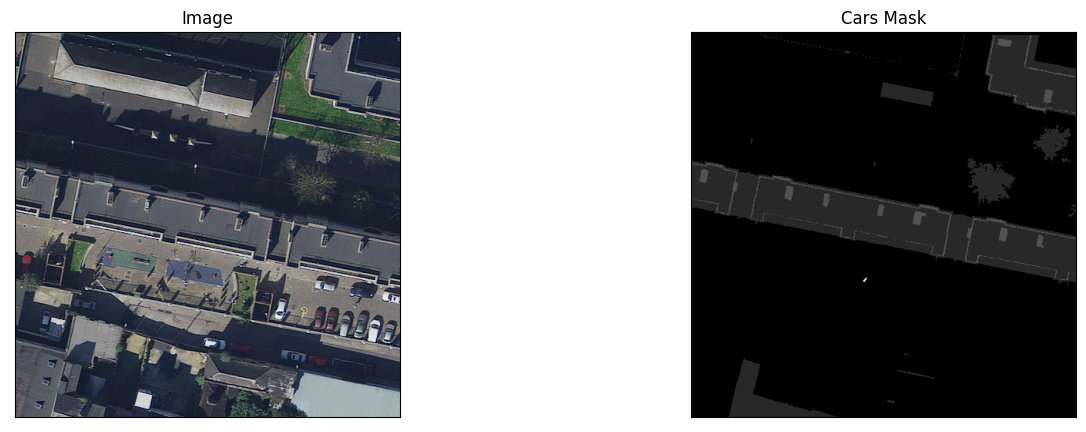

In [ ]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[45] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations as albu
import albumentations.augmentations.geometric.transforms as G
import albumentations.augmentations.crops.transforms as C
import torchvision.transforms as T

In [ ]:
def get_training_augmentation():
    train_transform = [
        
        albu.augmentations.geometric.resize.Resize(504,504),

        G.HorizontalFlip(p=0.5),

        #G.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        G.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=8, 
                      pad_width_divisor=8, border_mode=0),
        
        #C.RandomCrop(height=500, width=500, always_apply=True),

        #albu.IAAAdditiveGaussianNoise(p=0.2),
        #albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                #albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.augmentations.geometric.resize.Resize(504,504),
        G.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=8, pad_width_divisor=8)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/haris/anaconda3/envs/harispy/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/haris/anaconda3/envs/harispy/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(504, 504, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]


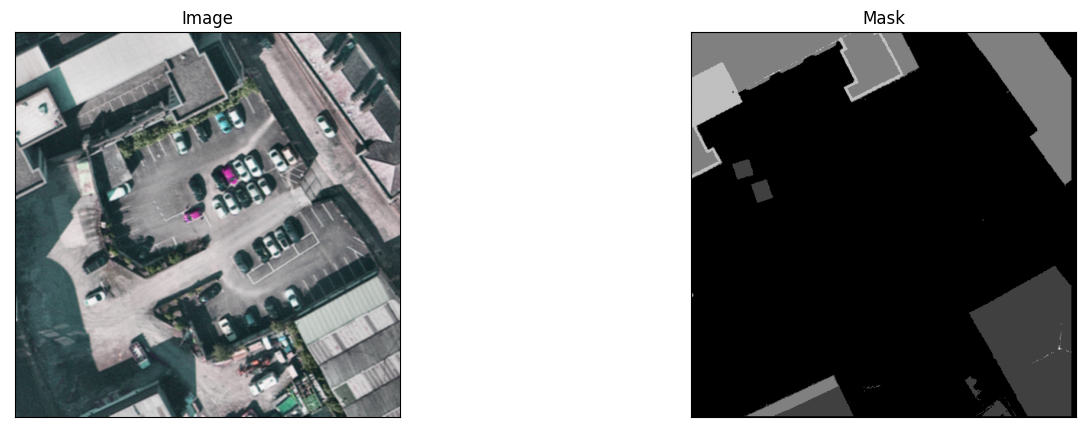

(504, 504, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]


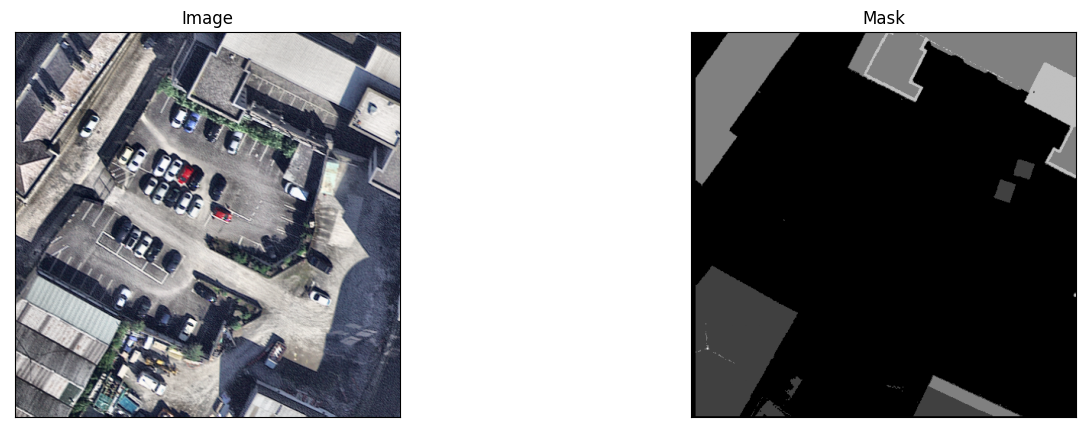

(504, 504, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]


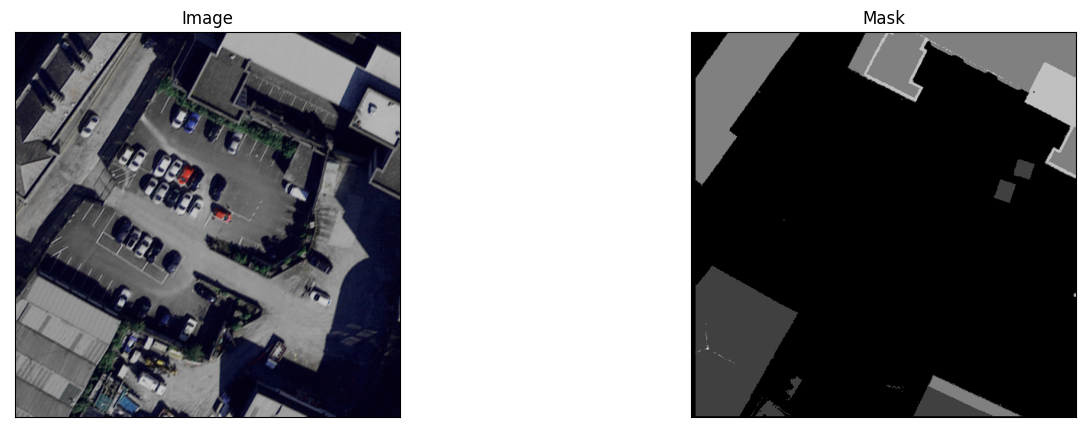

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=classes,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze())

## Create model and train

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = classes
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

/home/haris/anaconda3/envs/harispy/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex
from segmentation_models_pytorch import utils

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:31<00:00,  5.86it/s, dice_loss - 0.3135, iou_score - 0.5364]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:30<00:00,  6.07it/s, dice_loss - 0.2917, iou_score - 0.5599]
Model saved!

Epoch: 2
valid: 100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:30<00:00,  6.04it/s, dice_loss - 0.2719, iou_score - 0.5822]
Model saved!

Epoch: 3
valid: 100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.15it/s, dice_loss - 0.267, iou_score - 0.5886]
Model saved!

Epoch: 4
valid: 100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.14it/s, dice_loss - 0.2543, iou_score - 0.605]
Model saved!

Epoch: 5
valid: 100%|█████████████████████████████████

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|███████████████████████████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.47it/s, dice_loss - 0.1482, iou_score - 0.7517]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

(500, 500, 3)
(504, 504, 10)
[ 10.  30.  50.  70.  90. 115.]
(504, 504, 10)
[ 0. 10. 30. 50. 70. 90.]


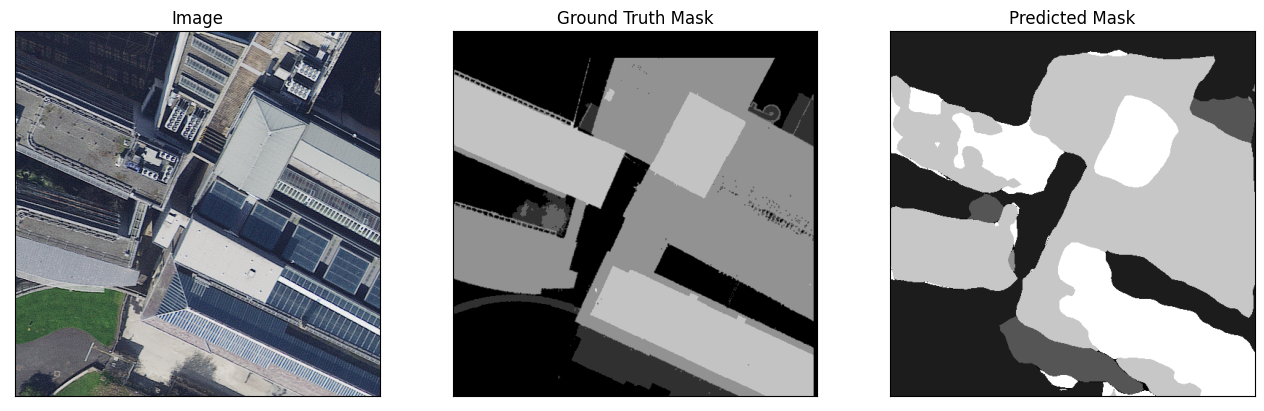

(500, 500, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]
(504, 504, 10)
[ 0. 10. 30. 50. 70.]


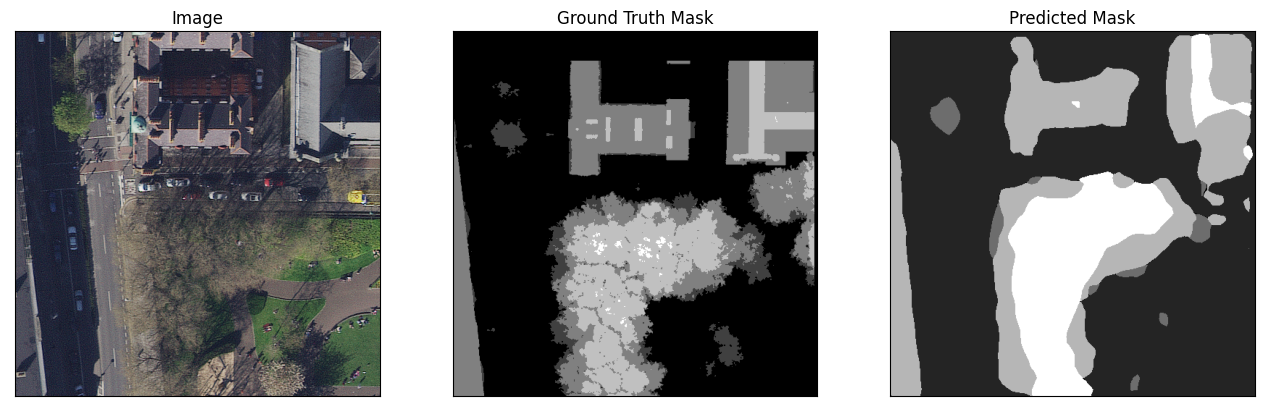

(500, 500, 3)
(504, 504, 10)
[ 10.  30.  50.  70.  90. 115.]
(504, 504, 10)
[ 0. 10. 30. 50. 70.]


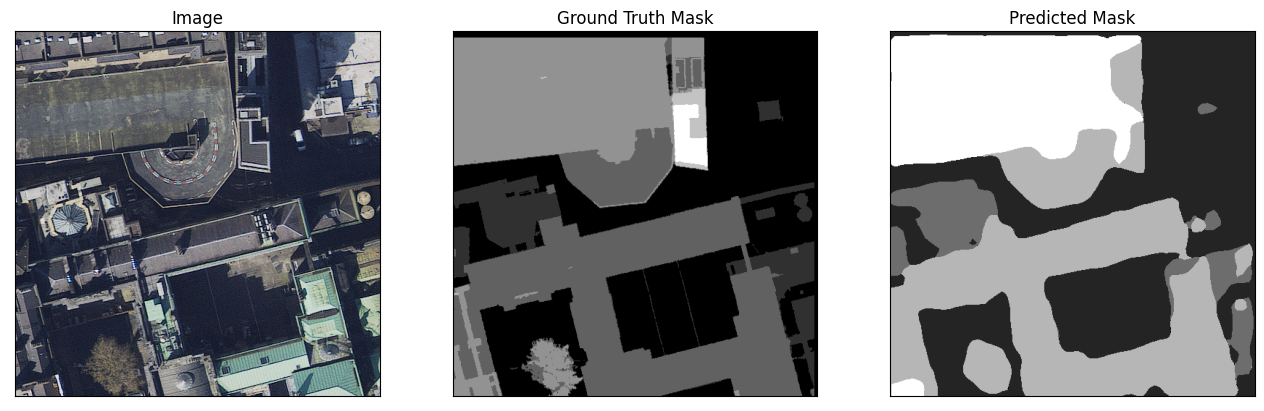

(500, 500, 3)
(504, 504, 10)
[10. 30. 50. 70.]
(504, 504, 10)
[ 0. 10. 30. 50. 70.]


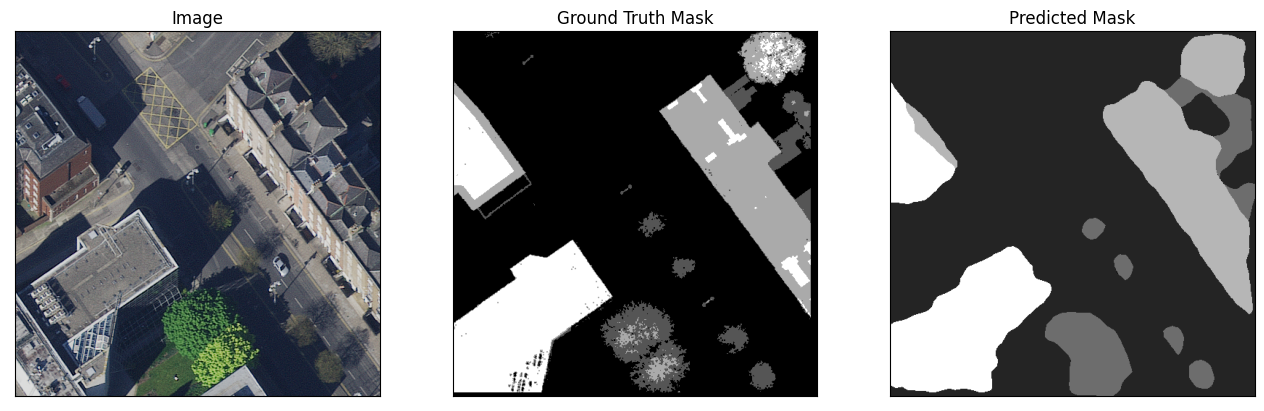

(500, 500, 3)
(504, 504, 10)
[ 10.  30.  50.  70.  90. 115.]
(504, 504, 10)
[ 0. 10. 30. 50. 70.]


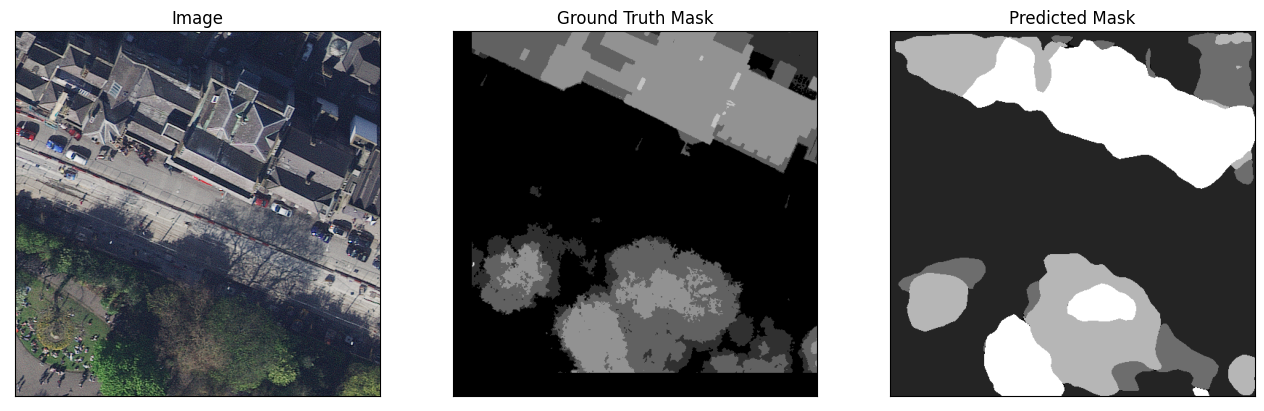

(500, 500, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]
(504, 504, 10)
[ 0. 10. 30. 50. 70.]


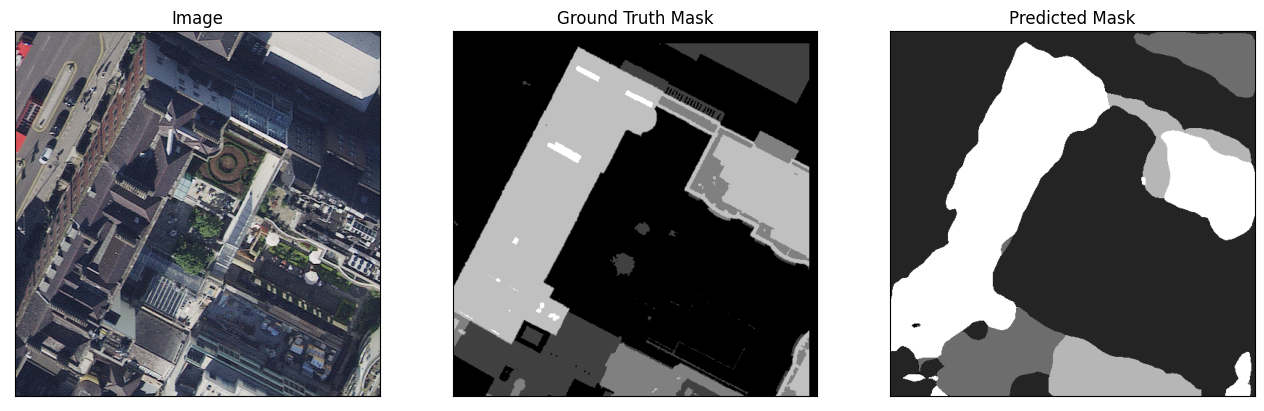

(500, 500, 3)
(504, 504, 10)
[10. 30. 50.]
(504, 504, 10)
[ 0. 10. 30.]


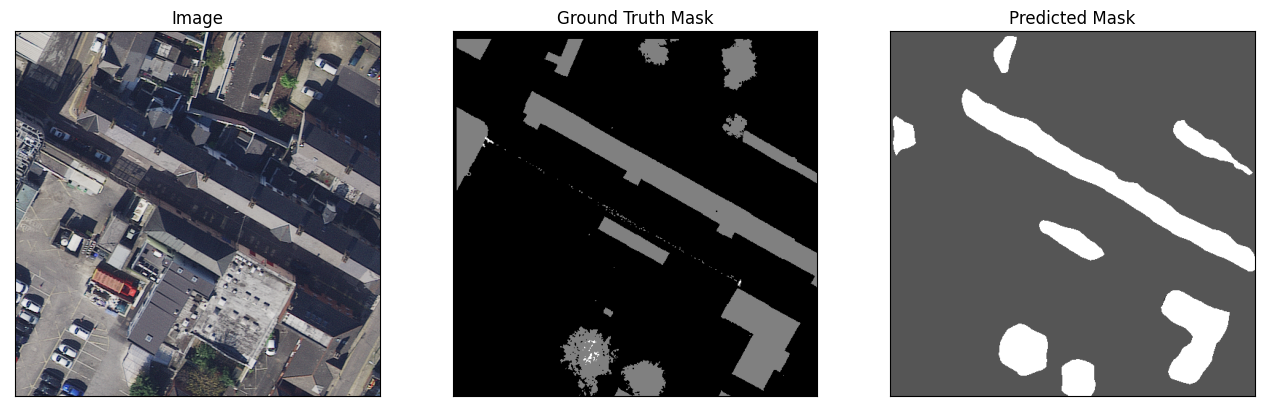

(500, 500, 3)
(504, 504, 10)
[10. 30. 50. 70. 90.]
(504, 504, 10)
[ 0. 10. 30. 50. 70. 90.]


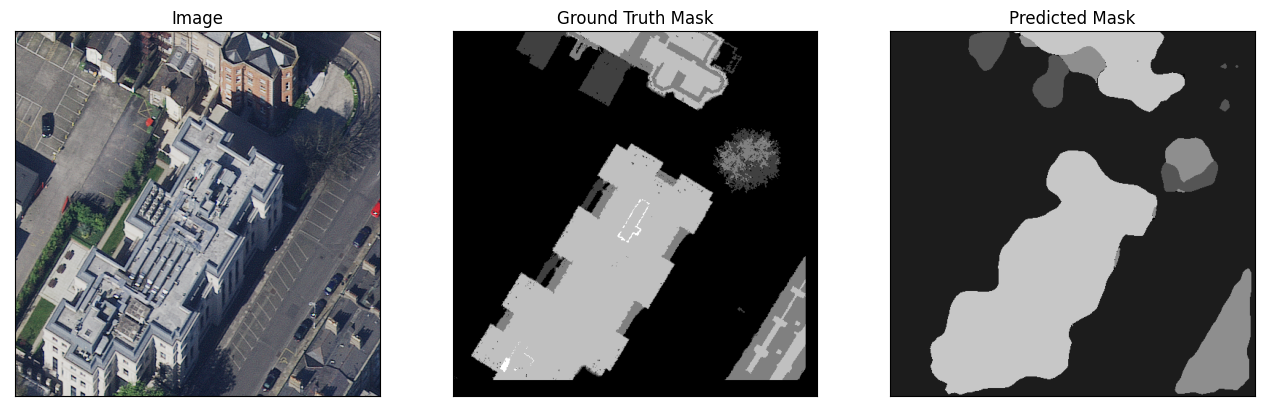

(500, 500, 3)
(504, 504, 10)
[10. 30. 50. 70.]
(504, 504, 10)
[ 0. 10. 30. 50. 70. 90.]


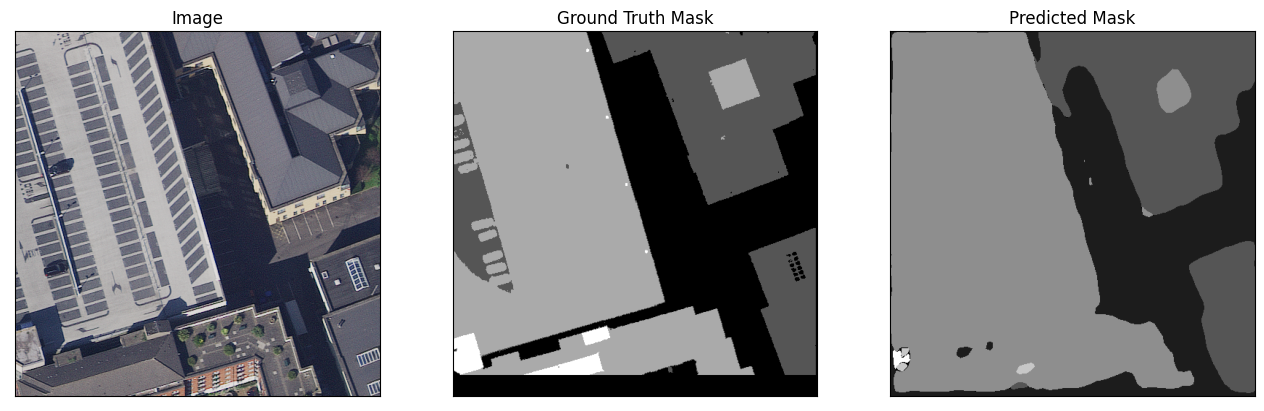

(500, 500, 3)
(504, 504, 10)
[ 10.  30.  50.  70.  90. 115. 135. 165.]
(504, 504, 10)
[ 0. 10. 30. 50. 70. 90.]


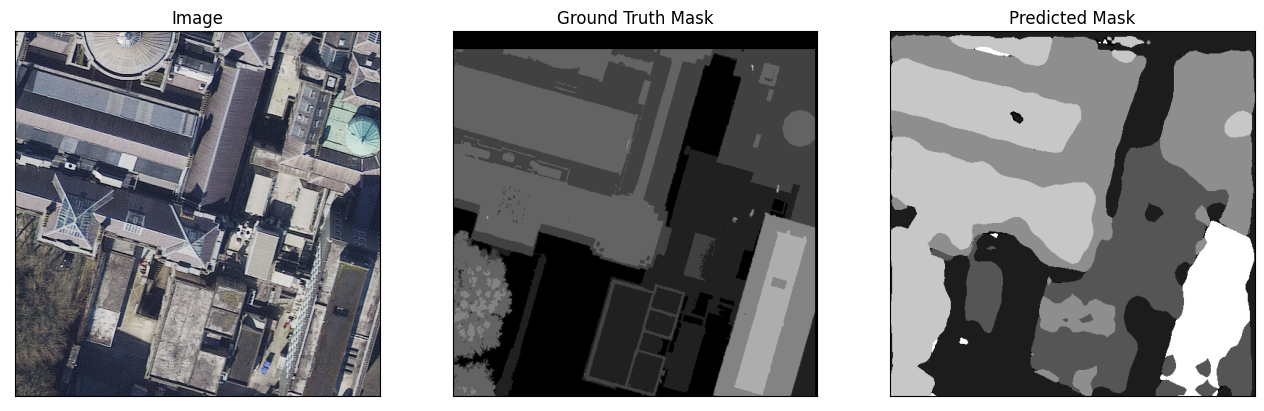

In [ ]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask2 = np.rollaxis(gt_mask,0,3)
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask2 = np.rollaxis(pr_mask,0,3)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask2, 
        predicted_mask=pr_mask2
    )